<a href="https://colab.research.google.com/github/Otter2022/Oil_Marketing_Campaign/blob/main/marketing_campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Environment Setup and Imports


In [ ]:
!pip install torch torchvision torchaudio
!pip install matplotlib pandas scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

#### Explanation of Imports:
- `pandas`: For data manipulation and analysis.
- `numpy`: For numerical operations.
- `torch`: The main PyTorch library.
- `torch.nn`: For building neural networks.
- `torch.optim`: For optimization algorithms.
- `torch.utils.data`: For data handling.
- `sklearn.model_selection`: For splitting the dataset.
- `matplotlib`: For plotting results.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
source_data_output = '/content/drive/MyDrive/ColabNotebooks/FinalProject_AI/Source_Data_Output/'
basepath = source_data_output
# tokens_file = basepath + 'tokens1_formatted_output.csv'
# tokens_file = basepath + 'tokens2_formatted_output.csv'
tokens_file = basepath + 'tokens3_formatted_output.csv'
# tokens_file = basepath + 'tokens4_formatted_output.csv'
# tokens_file = basepath + 'tokens5_formatted_output.csv'


### Step 2: Load and Pre-process the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
df = pd.read_csv(tokens_file)

In [ ]:
# Preprocess the data
# Create a mapping from name tokens to indices
all_names = set()
for name in df['column1'].tolist() + df['column2'].tolist():
    all_names.update(name.split())

name_to_idx = {name: idx for idx, name in enumerate(sorted(all_names))}
idx_to_name = {idx: name for name, idx in name_to_idx.items()}

def encode_name(name):
    return [name_to_idx[n] for n in name.split()]

def decode_name(indices):
    return ' '.join([idx_to_name[i] for i in indices])

df['input_encoded'] = df['column1'].apply(encode_name)
df['target_encoded'] = df['column2'].apply(encode_name)

# Padding sequences and creating tensors
def pad_sequence(seq, max_len, pad_value):
    return seq + [pad_value] * (max_len - len(seq))

max_len = max(df['input_encoded'].apply(len).max(), df['target_encoded'].apply(len).max())

X = np.array([pad_sequence(x, max_len, len(name_to_idx)) for x in df['input_encoded']])
y = np.array([pad_sequence(y, max_len, len(name_to_idx)) for y in df['target_encoded']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

### Step 3: Create a Custom Dataset and DataLoader

In [ ]:
class NameDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = NameDataset(X_train_tensor, y_train_tensor)
test_dataset = NameDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

### Step 4: Define the Seq2Seq Model with LSTM

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(Seq2Seq, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, src, tgt):
        embedded_src = self.embedding(src)
        encoder_outputs, (hidden, cell) = self.encoder(embedded_src)

        embedded_tgt = self.embedding(tgt)
        decoder_outputs, _ = self.decoder(embedded_tgt, (hidden, cell))

        outputs = self.fc(decoder_outputs)
        return outputs

### Step 5: Train the Model

In [ ]:
# Hyperparameters
vocab_size = len(name_to_idx) + 1
embedding_dim = 128
hidden_dim = 256
output_dim = vocab_size
num_layers = 2
num_epochs = 20
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = Seq2Seq(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
criterion = nn.CrossEntropyLoss(ignore_index=len(name_to_idx))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, targets)
        loss = criterion(outputs.view(-1, output_dim), targets.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}')

Epoch 1/20, Loss: 5.1701
Epoch 2/20, Loss: 1.9252
Epoch 3/20, Loss: 0.8079
Epoch 4/20, Loss: 0.2711
Epoch 5/20, Loss: 0.0443
Epoch 6/20, Loss: 0.0138
Epoch 7/20, Loss: 0.0084
Epoch 8/20, Loss: 0.0057
Epoch 9/20, Loss: 0.0041
Epoch 10/20, Loss: 0.0029
Epoch 11/20, Loss: 0.0021
Epoch 12/20, Loss: 0.0016
Epoch 13/20, Loss: 0.0011
Epoch 14/20, Loss: 0.0009
Epoch 15/20, Loss: 0.0006
Epoch 16/20, Loss: 0.0005
Epoch 17/20, Loss: 0.0004
Epoch 18/20, Loss: 0.0003
Epoch 19/20, Loss: 0.0002
Epoch 20/20, Loss: 0.0002


### Step 6: Visualize Training Loss

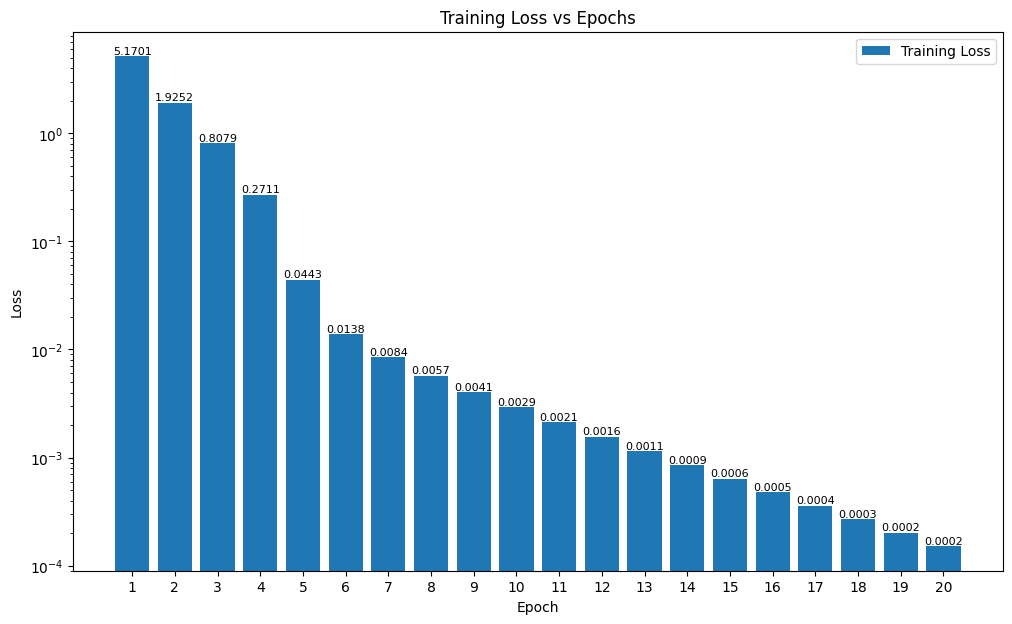

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
#plot bars
# Plot the training losses as bars
#make text over the bar smaller

bars = plt.bar(range(1, num_epochs + 1), train_losses, label='Training Loss')
# Add text over the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}',
             ha='center', va='bottom', fontsize=8)
plt.xlabel('Epoch')
plt.xticks(range(1, num_epochs + 1))
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.yscale('log')
plt.legend()
plt.show()


### Step 7: Evaluate the Model

In [ ]:
model.eval()
matches = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs, targets)
        predicted = torch.argmax(outputs, dim=2)
        for i in range(len(inputs)):
            input_name = decode_name(inputs[i].tolist())
            target_name = decode_name(targets[i].tolist())
            predicted_name = decode_name(predicted[i].tolist())

            # Ignore padding tokens in the target and predicted names
            target_name = target_name.split(' <PAD>')[0]
            predicted_name = predicted_name.split(' <PAD>')[0]

            if target_name == predicted_name:
                matches += 1
            total += 1
            print(f'Input: {input_name}\nTarget: {target_name}\nPredicted: {predicted_name}\n')

    accuracy = matches / total
    print(f'Accuracy: {accuracy*100:.4f}%')


Streaming output truncated to the last 5000 lines.
Target: Gerald Ferrell Tucker
Predicted: Gerald Ferrell Tucker

Input: NATINO JOANA EST
Target: Joana Est Natino
Predicted: Dona Est Godwin

Input: MANCHA ANDY BRIANA
Target: Andy Briana Mancha
Predicted: Andy Ryan Mancha

Input: HOWARD MILTON F
Target: Milton F Howard
Predicted: Milton F Howard

Input: WILLIS E KAY
Target: E Kay Willis
Predicted: E Kay Willis

Input: KIMMELL THOMAS A
Target: Thomas A Kimmell
Predicted: Thomas A Kimmell

Input: WORKMAN LULA ANN
Target: Lula Ann Workman
Predicted: Lula Ann Workman

Input: STOWE JOHN D
Target: John D Stowe
Predicted: John D Stowe

Input: HOUDYSHELL MARY RUTH
Target: Mary Ruth Houdyshell
Predicted: Mary Ruth Gallaway

Input: MORGAN THEORDORE EDWARD
Target: Theordore Edward Morgan
Predicted: Laforce Edward Morgan

Input: PICKENS W C
Target: W C Pickens
Predicted: W C Pickens

Input: NOLL SHARON E
Target: Sharon E Noll
Predicted: Sharon E Noll

Input: BASSHAM KATIE WILSON
Target: Katie Wils

### Summary of Steps

1. **Install and Import Libraries**
2. **Load and Preprocess Data**
3. **Create Custom Dataset and DataLoader**
4. **Define Seq2Seq Model**
5. **Train the Model**
6. **Visualize Training Loss**
7. **Evaluate the Model**